# Classifing Injury Code based on Occupational Injury Report

Every day, work-related injury records are generated. In order to alleviate the human effort expended with coding such records, the Centers for Disease Control and Prevention (CDC) National Institute for Occupational Safety and Health (NIOSH), in close partnership with the Laboratory for Innovation Science at Harvard (LISH), is interested in improving their NLP/ML model to automatically read injury records and classify them according to the Occupational Injury and Illness Classification System (OIICS).

https://www.topcoder.com/challenges/30103825

OIICS Coding Scheme Definitions: https://wwwn.cdc.gov/wisards/oiics/

## Load the Data

The input training file is a cvs file (with a header) with 4 columns (`text`, `sex`, `age`, and `event`) and 153956 observations.

1. `text`; This column describes the raw injury description text data.

2. `sex`; This is a categorical variable, describing the sex of the related person.

3. `age`; This is a positive integer variable, describing the age of the related person.

4. `event`; This is the target variable, specifying the OIICS label to be classified. There are 48 unique labels in total.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Load data
data = pd.read_csv('train.csv')

In [3]:
# Examine head of df

data.head()

,text,sex,age,event
0,57YOM WITH CONTUSION TO FACE AFTER STRIKING IT...,1,57,62
1,A 45YOM FELL ON ARM WHILE WORKING HAD SLIPPED ...,1,45,42
2,58YOM WITH CERVICAL STRAIN BACK PAIN S P REST...,1,58,26
3,33 YOM LAC TO HAND FROM A RAZOR KNIFE,1,33,60
4,53YOM AT WORK IN A WAREHOUSE DOING UNSPECIFIED...,1,53,71


In [4]:
# Examine df info

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153956 entries, 0 to 153955
Data columns (total 4 columns):
text     153956 non-null object
sex      153956 non-null int64
age      153956 non-null int64
event    153956 non-null int64
dtypes: int64(3), object(1)
memory usage: 4.7+ MB


In [5]:
# Look at numerical data

data.describe()

,sex,age,event
count,153956.000000,153956.00000,153956.000000
mean,1.354361,38.28868,54.850808
std,0.478321,13.26070,18.526890
min,1.000000,0.00000,10.000000
25%,1.000000,27.00000,43.000000
50%,1.000000,37.00000,62.000000
75%,2.000000,48.00000,70.000000
max,2.000000,96.00000,99.000000


While there do not appear to be any null values, there are min values in the `age` column equal to 0. These are most likely placeholder values for unknown data and will need to be evaluated further. If the age of the injured person can not be determined from the `text`, these values will be imputed with the median value of the `age` column, 37 years old.

In [6]:
# Analyze placeholder values for age

zero_age = data.loc[data.age == 0]
zero_age

,text,sex,age,event
7323,UNK AGE FEMALE ACCIDENTALLY CUT SELF W DIRTY S...,2,0,55
17671,UNK AGE MALE IS A PARKING ATTENDANT AT WORK AN...,1,0,73
24760,UNK AGE MALE C O DOING HEAVY LIFTING AT WORK A...,1,0,71
26503,UNKNOWN AGE MALE WITH EXPOSURE TO CARBON DIOXI...,1,0,55
34429,UNID D MALE WAS THE DRIVER OF A TRACTOR TRAILE...,1,0,26
34890,UNID D MALE WAS COOKING A RETAURANT WHEN PRES...,1,0,32
41930,UNKNOWN AGE MALE WITH EXPOSURE TO CARBON DIOXI...,1,0,55
44621,UNK AGE MALE SUSTAINED AN ELECTRICAL SHOCK AND...,1,0,43
45835,UKN YOM WITH MULTIPLE TRAUMATIC INJURIES AFTER...,1,0,65
58278,UNKNOWN AGE MALE WITH EXPOSURE TO CARBON DIOXI...,1,0,55


Only instance 133289 has the age of the injured person in the text of the report. Thus, it will be set to 13 and the rest of the observations will be set to equal the median value for the `age` column, 37 years old.

In [7]:
# Correct age value for instance 133289

data.loc[133289, 'age'] = 13

# Check

data.iloc[133289]

text     A 13YOF SUSTAINED NEEDLESTICK WHILE OPENING UP...
sex                                                      2
age                                                     13
event                                                   61
Name: 133289, dtype: object

In [8]:
# Impute the median age for the 0 values in the age column

data.age.replace(0, np.median(data.age), inplace=True)

# Check

data.describe()

,sex,age,event
count,153956.000000,153956.000000,153956.000000
mean,1.354361,38.294532,54.850808
std,0.478321,13.251886,18.526890
min,1.000000,5.000000,10.000000
25%,1.000000,27.000000,43.000000
50%,1.000000,37.000000,62.000000
75%,2.000000,48.000000,70.000000
max,2.000000,96.000000,99.000000


This data comes from the CDC and is assumed to be represent injuries from people employed in the US. However, the minimum age in the dataset is less than the legal age of employment (14 years old) set by the US Department of Labor. Let's select a few observations to investigate further if these observations represent injured child laborers or if they are just children injured on work sites.

In [9]:
kids = data.loc[data.age < 14]
print(kids.shape)
sample = kids.sample(n=10)
sample.reset_index(inplace=True)

for i in range(0,len(sample)):
    print(sample.iloc[i].text)
    print('\n')

(94, 4)
11YOF WORKING WITH HER COW ON THE FARM THE COW STEPPED ON HER   HAND  DX CONTUSION HAND


13YOF CONTUSION TO HIP FELL ON A ROCK WHEN CLENING THE STABLE THE ALSO HIT HIP ON STABLE DOOR


R WRST SPR 13YOWM DELIVERING NEWSPAPERS ON BIKE WAS HIT BY CAR THAT CA ME FROM STOP HIT PT S BACK TIRE PT FELL TO R SIDE NO LOC OR HELMET WORN


12 YOM C O INJURIES AFTER THE SMALL TRACTOR POPPED OUT OF GEAR AND ROLLED OVER HIM WHILE TRYING TO HOOK UP THE CART DX CONCUSSION CONTUSIONS


13YOM WITH NEAR AVULSION TO LEFT FINGERTIP WHEN IT WAS CAUGHT BETWEEN ATRUCK BOX AND HYDRAULIC BALE MOWER


12YOM WAS WORKING ON PARENT S FARM WAS CLIMBING ON A BENCH SLIPPED  FELL ON A RUSTY RAKE PUNCTURE WOUND TO KNEE


13 YOF A VOLUNTEER AT HORSEBACK RIDING CAMP WHEN A HORSE STEPPED ONHER FOOT DX CONTUSION FOOT


8 YOM DX EYE ITCHING AND SWELLING  DUE TO SOMETHING FELL IN EYE AT  WORK


A 13YOF SUSTAINED NEEDLESTICK WHILE OPENING UP CAPPED INSULIN PEN PUNCT TO FINGER


8YOF LASSOING CATTLE ON FARM TRIPPED ON R

Hmm...okay they seem like actual work-related injuries...

## Exploratory Data Analysis

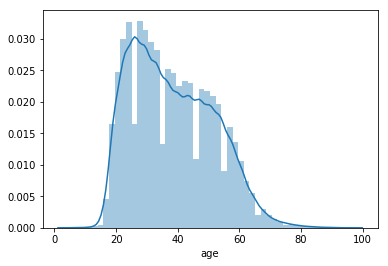

In [10]:
sns.distplot(data.age)
plt.show()

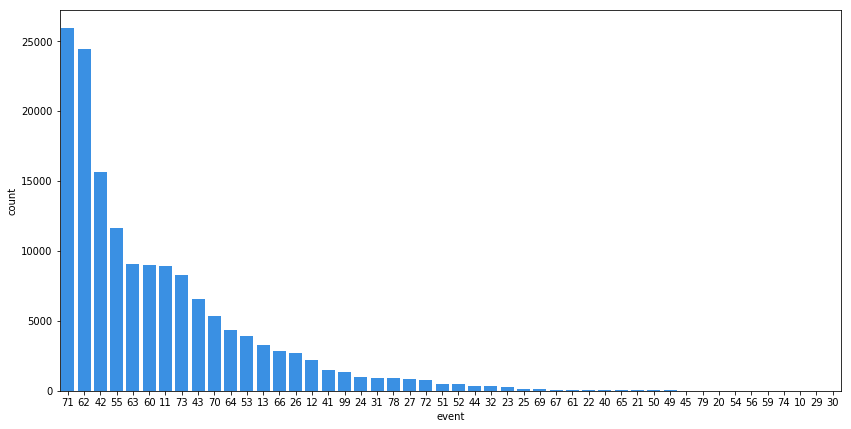

In [12]:
fig = plt.figure(figsize=(14,7))
sns.countplot(data.event, order=data.event.value_counts().index, color='dodgerblue')
plt.show()

In [13]:
data['event_group'] = [0] * len(data)

data.loc[(data.event<20), 'event_group'] = 'Violence by person or animal'
data.loc[(data.event>=20) & (data.event<30), 'event_group'] = 'Transportation incidents'
data.loc[(data.event>=30) & (data.event<40), 'event_group'] = 'Fires and Explosions'
data.loc[(data.event>=40) & (data.event<50), 'event_group'] = 'Falls, Slips, Trips'
data.loc[(data.event>=50) & (data.event<60), 'event_group'] = 'Exposure to harmful substances or environments'
data.loc[(data.event>=60) & (data.event<70), 'event_group'] = 'Contact with objects and equipment'
data.loc[(data.event>=70) & (data.event<80), 'event_group'] = 'Overexertion and Bodily Reaction'
data.loc[(data.event>=99), 'event_group'] = 'Unclassifiable'

data.head()


,text,sex,age,event,event_group
0,57YOM WITH CONTUSION TO FACE AFTER STRIKING IT...,1,57,62,Contact with objects and equipment
1,A 45YOM FELL ON ARM WHILE WORKING HAD SLIPPED ...,1,45,42,"Falls, Slips, Trips"
2,58YOM WITH CERVICAL STRAIN BACK PAIN S P REST...,1,58,26,Transportation incidents
3,33 YOM LAC TO HAND FROM A RAZOR KNIFE,1,33,60,Contact with objects and equipment
4,53YOM AT WORK IN A WAREHOUSE DOING UNSPECIFIED...,1,53,71,Overexertion and Bodily Reaction


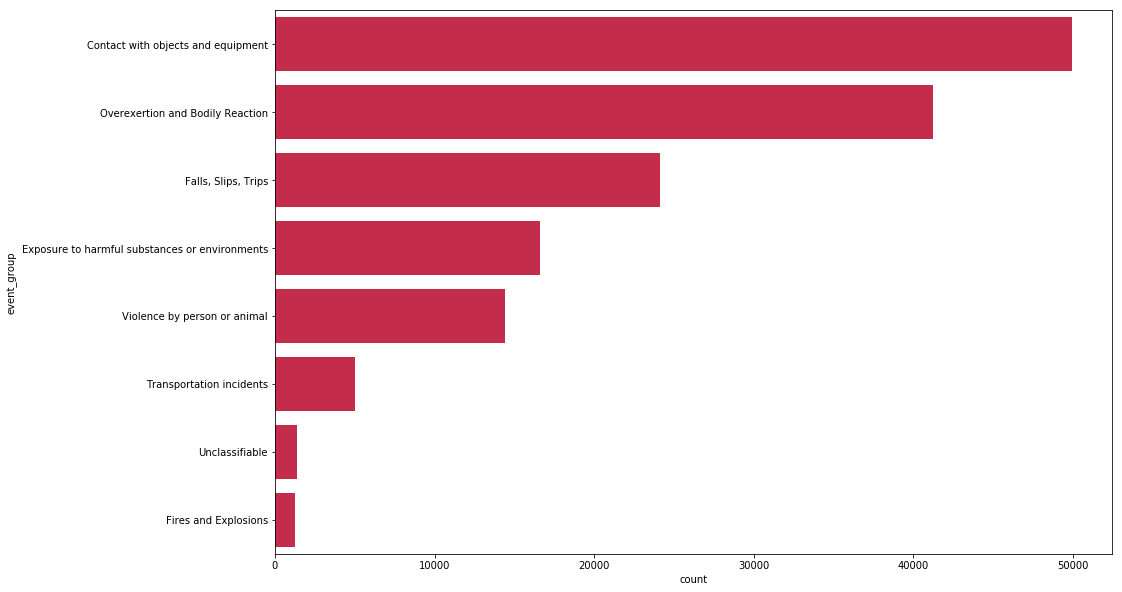

In [14]:
fig = plt.figure(figsize=(15,10))
sns.countplot(y='event_group',
              data=data,
              #orient="h",
              order=data.event_group.value_counts().index, 
              color='crimson')

plt.show()

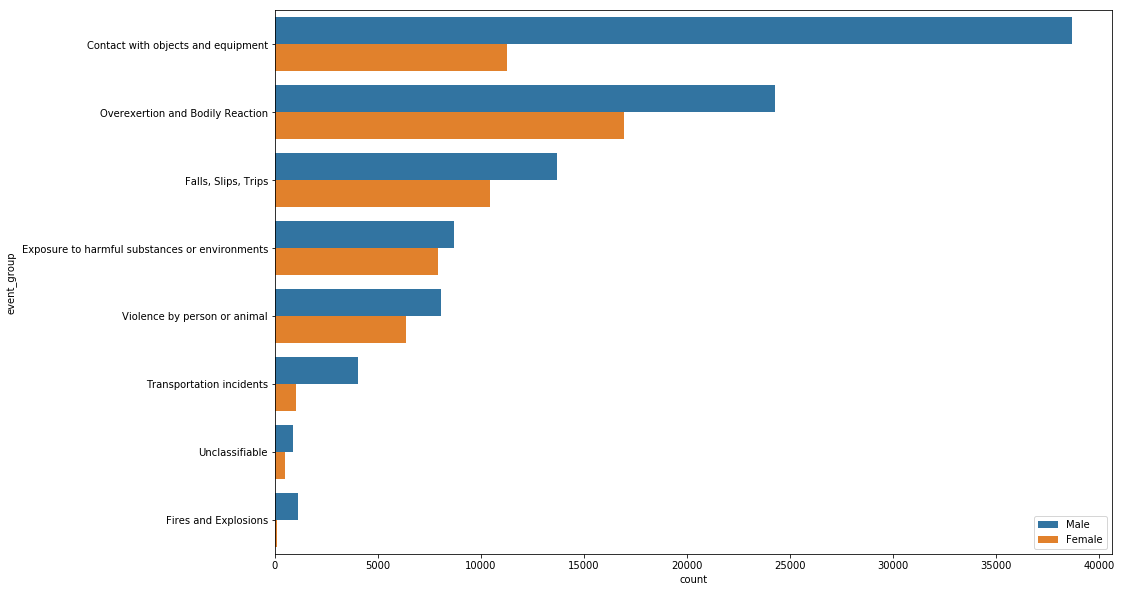

In [205]:
fig = plt.figure(figsize=(15,10))
sns.countplot(y='event_group',
              data=data,
              hue='sex',
              order=data.event_group.value_counts().index, 
              )
plt.legend(['Male', 'Female'])
plt.show()

In [15]:
import spacy

nlp = spacy.load("en_core_web_md")

In [16]:
import re

In [17]:
def get_body_part(txt):
    pattern_head = "(HEAD|NECK|FACE|EYE|NOSE|MOUTH|TEETH|TOOTH|TONGUE|LIP|CHIN|SKULL|EAR|CHEEK)"
#     p_head = re.compile(pattern_head)
#     result_head = p_head.findall(txt)
    
    pattern_arm = "(HAND|FINGER|THUMB|WRIST|ARM|SHOULDER|ELBOW|BICEP|TRICEP|FOREARM)"
#     p_arm = re.compile(pattern_arm)
#     result_arm = p_arm.findall(txt)
    
    pattern_trunk = "(CHEST|BACK|RIB|STOMACH|STERNUM|COLLAR|CLAVICAL|ORGAN|KIDNEY|LIVER|HEART|LUNG|INTESTINE|SPINE)"
#     p_trunk = re.compile(pattern_trunk)
#     result_trunk = p_trunk.findall(txt)
    
    pattern_leg = "(FOOT|FEET|TOE|ANKLE|HEEL|SHIN|KNEE|LEG|THIGH|CALF|CALVES|HIP|BUTTOCK|GLUTE|BUTT|COCCYX|PELVIS|GENITALS|HAMSTRING|QUAD)"
#     p_leg = re.compile(pattern_leg)
#     result_leg = p_leg.findall(txt)
    
    pattern_list = [(pattern_head, 'head/neck'), 
                    (pattern_arm, 'arms'),
                    (pattern_trunk, 'trunk'),
                    (pattern_leg, 'legs')]
    
    result_list = []
    
    
    for i in range(0, len(txt)):
        body_parts = []
        for pattern in pattern_list:
            p = re.compile(pattern[0])
            results = p.findall(txt[i])
            
            if len(results) > 0:
            
                body_parts.append(pattern[1])
                
            else:
                
                pass

        result_list.append((i, body_parts))
            
    return result_list

In [19]:
test = get_body_part(data.text)
print(len(test),len(data.text))

153956 153956


In [20]:
def get_context(txt):
    pattern1 = "(PUNCH|KICK|BITE|SCRATCH|ATTACK|HARM|FIGHT|STAB|SHOOT|INFLICT|ANIMAL|INSECT|VENOM|INTENT)"

    pattern2 = "(AIRCRAFT|VEHICLE|PLANE|CAR|BIKE|CYCLE|ROADWAY|PEDESTRIAN|TRAIN|MOTOR)"

    
    pattern3 = "(FIRE|BOMB|EXPLOSION|EXPLODE|IGNITION|PRESSURE|BLAST)"

    
    pattern4 = "(FALL|SLIP|TRIP|JUMP)"
    
    pattern5 = "(EXPOSURE|SUBSTANCE|CHEMICAL|ENVIRONMENT|RADIATION|EXTREME|EXPOSE|ELECTRIC|TEMPERATURE)"
    
    pattern6 = "(NEEDLE|MACHINE|CONTACT|STRUCK|EQUIP|COLLAPS|CRUSH|FRICTION)"
    
    pattern7 = "(EXERT|BODILY|HEAVY|LIFT|PUSH|OBJECT|REPETITIVE|REPEAT)"
    

    
    pattern_list = [(pattern1, 'violence people/animal'), 
                    (pattern2, 'transportation'),
                    (pattern3, 'fires/explosions'),
                    (pattern4, 'falls/slips/trips'),
                    (pattern5, 'exposure'),
                    (pattern6, 'objects/equipment'),
                    (pattern7, 'overexertion')]
    
    result_list = []
    
    
    for i in range(0, len(txt)):
        groups = []
        for pattern in pattern_list:
            p = re.compile(pattern[0])
            results = p.findall(txt[i])
            
            if len(results) > 0:
            
                groups.append(pattern[1])
                
            else:
                
                pass
        if len(groups) < 1:
            groups.append('None')

        result_list.append((i, groups))
            
    return result_list

In [21]:
test2 = get_context(data.text)
print(len(test2), len(data.text))

153956 153956


In [22]:
print(test2[48])
print(test2[49])
print(test2[50])

(48, ['falls/slips/trips'])
(49, ['falls/slips/trips'])
(50, ['fires/explosions'])


In [23]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

from nltk.collocations import *
from nltk import FreqDist
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import string # to remove punctuation
# from gensim.models import Word2Vec

In [24]:
data.head()

,text,sex,age,event,event_group
0,57YOM WITH CONTUSION TO FACE AFTER STRIKING IT...,1,57,62,Contact with objects and equipment
1,A 45YOM FELL ON ARM WHILE WORKING HAD SLIPPED ...,1,45,42,"Falls, Slips, Trips"
2,58YOM WITH CERVICAL STRAIN BACK PAIN S P REST...,1,58,26,Transportation incidents
3,33 YOM LAC TO HAND FROM A RAZOR KNIFE,1,33,60,Contact with objects and equipment
4,53YOM AT WORK IN A WAREHOUSE DOING UNSPECIFIED...,1,53,71,Overexertion and Bodily Reaction


In [32]:
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)

def stop_and_tokenize_text (txt):
    
    text = txt.lower()
    
    tokens = word_tokenize(text)
    
    stopped_tokens = [w for w in tokens if w not in stopwords_list]
    
    return stopped_tokens

In [33]:
data['tokenized'] = data.text.apply(stop_and_tokenize_text)
data.head()

,text,sex,age,event,event_group,tokenized
0,57YOM WITH CONTUSION TO FACE AFTER STRIKING IT...,1,57,62,Contact with objects and equipment,"[57yom, contusion, face, striking, post, pound..."
1,A 45YOM FELL ON ARM WHILE WORKING HAD SLIPPED ...,1,45,42,"Falls, Slips, Trips","[45yom, fell, arm, working, slipped, water, fx..."
2,58YOM WITH CERVICAL STRAIN BACK PAIN S P REST...,1,58,26,Transportation incidents,"[58yom, cervical, strain, back, pain, p, restr..."
3,33 YOM LAC TO HAND FROM A RAZOR KNIFE,1,33,60,Contact with objects and equipment,"[33, yom, lac, hand, razor, knife]"
4,53YOM AT WORK IN A WAREHOUSE DOING UNSPECIFIED...,1,53,71,Overexertion and Bodily Reaction,"[53yom, work, warehouse, unspecified, lifting,..."


In [35]:
def create_vector_df(vector_df):
    '''This function converts a dataframe where each instance is the vector for a particular word in the form of a
    list into a dataframe where each column represents a dimension from the vector. The function assumes all vectors
    are the same shape. Designed to be used as a helper function with the get_spacy_vectors function.
    
    vector_df: a column from a pandas dataframe where each row contains a word vector in the form of a python list
    
    returns a pandas dataframe where each column represents one of the dimensions from the vector and each row is 
    an individual vector
    
    '''
    
    # List to hold individual, transposed vectors
    df = []
    # Loop through each instance
    for i in list(range(0,len(vector_df.vector))):
        # Put vector into a dataframe and transpose; (n,1) --> (1,n)
        vectors = pd.DataFrame(vector_df.vector[i]).T
        # Store individual, transposed vector in a list for subsequent concatenation
        df.append(vectors)
    # Combine all individual, transposed vectors into a single dataframe
    vecs_df = pd.concat(df, axis=0)
    
    return vecs_df


def get_spacy_vectors(text):
    '''Function designed to grab the english SpaCy vectors for the words in a specific corpus and return them in a
    dataframe where each row corresponds to a specific vector and where each column represents one of the dimensions 
    of the vector.
    
    text: tokenized string; designed to take in a column from a pandas dataframe with tokenized texts as intances
    
    returns a pandas dataframe where each column represents one of the dimensions from the vector and each row is 
    an individual vector
    
    '''
    # Instantiate a dictionary to hold word vectors
    word_vecs = {}
    
    # Loop through each tokenized document in the input text
    for doc in text:
        # Loop through each token in the text instance
        for word in doc:
            # Conditional to detemine if the text instance word is in SpaCy's embedded vocabulary
            if word in nlp.vocab:
                # Create a word:vector entry in the word_vecs dictionary
                word_vecs[word] = nlp.vocab[word].vector
            # Discard the text instance word if not in SpaCy's embedded vocabulary
            else:
                continue
    # Create a dataframe where each instance holds the word's vector as a list
    vec_df = pd.DataFrame()
    vec_df['vector'] = [word_vecs[x] for x in list(word_vecs.keys())]
    vec_df['word'] = [x for x in list(word_vecs.keys())]
    
    # Use the create_vector_df helper function to convert the vectors stored as lists into their own dataframe
    vectors_df = create_vector_df(vec_df)
    
    return vectors_df

In [127]:
# Sample each of the 8 different major categories of injury claims

def get_vectors_by_group (df, grp_col, n_sample, grp_list, text_col):
    
    grp_vectorized = []
    
    for grp in grp_list:
        grp_df = df[df[grp_col] == grp]
        
        sample = grp_df.sample(n=n_sample, random_state=26)
        
        grp_vecs = get_spacy_vectors(sample[text_col])
        
        grp_vectorized.append((grp, grp_vecs))
        
    return grp_vectorized

In [128]:
groups = ['Contact with objects and equipment', 'Falls, Slips, Trips',
'Transportation incidents', 'Overexertion and Bodily Reaction',
'Exposure to harmful substances or environments',
'Violence by person or animal', 'Unclassifiable',
'Fires and Explosions']

grp_to_vec = get_vectors_by_group(data, 'event_group', 600, groups, 'tokenized')

In [129]:
grp_to_vec[0][1].head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.002837,0.029502,-0.078415,-0.276090,-0.341390,0.25228,-0.32558,-0.34949,0.135360,2.21870,...,-0.442200,-0.531590,0.299950,0.450870,0.070206,-0.143590,0.571500,-0.27858,-0.108280,0.307910
0,-0.342340,-0.006001,-0.484450,0.035302,-0.097469,0.56999,-0.22360,0.12668,0.376260,0.61294,...,0.358130,-0.315400,-0.511700,-0.153860,0.224350,-0.138290,-0.236050,-0.52713,-0.046381,0.209960
0,0.115570,-0.000923,-0.391370,-0.339040,-0.234380,-0.80601,-0.68909,1.06510,-0.154550,0.74594,...,-0.011675,-0.761930,-0.003082,-0.076599,0.167370,-0.353430,-0.764750,-0.49123,-0.702710,0.228490
0,0.042168,0.336430,-0.290820,-0.214230,-0.402020,0.50948,0.27164,-0.33041,0.156030,0.50138,...,0.201580,-0.484690,0.306240,-0.324850,0.341220,-0.059297,0.068063,-0.15341,-0.540990,0.193950
0,0.054071,0.111100,-0.145570,-0.024294,0.381100,-0.14389,-0.17998,-0.31079,-0.007969,2.65380,...,-0.224790,-0.034352,-0.082647,-0.134850,-0.113710,-0.072454,-0.073029,-0.27098,0.044033,0.003769


In [130]:
def pca_3d(grps_vectors, title, elev=None, rotate=None):
    ''' Function designed to reduce (via PCA) the high-dimensional word vectors to three 
    dimensions with the intention of plotting their relationship. 
    
    grps_vectors: tuple containing the group name and a pandas dataframe containing the word 
    vectors where each row represents and entire vector and each column represents a dimension
    of the vectors >> ex. ('group name', vector_df)
    
    title: string denoting the title of the plot
    
    elev: integer pertaining to what elevation to apply to the view of the 3d plot
    
    rotate: integer pertaining to what angle to apply to the view of the 3d plot
    
    returns a three dimensional plot at the specified viewing angle
    
    '''
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111, projection='3d')
    
    pca = PCA(n_components=3)
    
    for i in range(0,len(grps_vectors)):
        vec_df = grps_vectors[i][1]
        pca_vec = pca.fit_transform(vec_df)
        results = pd.DataFrame(data=pca_vec, columns=['pc1', 'pc2', 'pc3'])
        ax.scatter(results['pc1'],
                   results['pc2'],
                   results['pc3'],
                   alpha=0.3,
                   label=grps_vectors[i][0])
        
    ax.set_title(title)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.view_init(elev, rotate)
    plt.legend()
    plt.show()


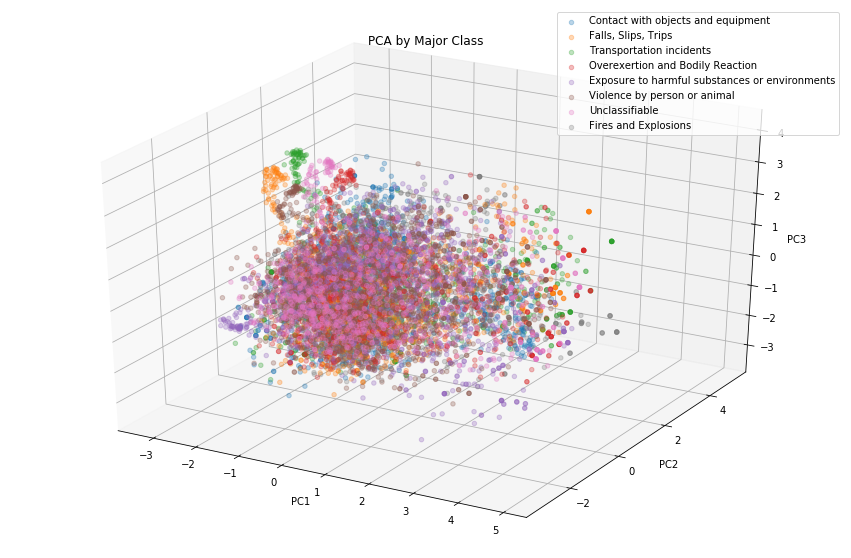

In [140]:
pca_3d(grp_to_vec, 'PCA by Major Class')

In [ ]:
def get_freq_dist_by_group (df, grp_col, top_n, grp_list, text_col):
    
    grp_freq = []
    
    for grp in grp_list:
    
        grp_df = df[df[grp_col] == grp] # change to grp if going back to loop

        all_tokens = []

        for i in grp_df[text_col]:
            for t in i:
                all_tokens.append(t)

        freqdist = FreqDist(all_tokens)

        most_common = freqdist.most_common(top_n)

    #     freq_df = pd.DataFrame(columns=['group', 'most_common'])

    #     words_common = []
    #     for n in most_common:
    #         words_common.append(n[0])


    #     freq_df['group'] = grp # change to grp if going back to loop
    #     freq_df['most_common'] = list(words_common)



        grp_freq.append((grp, most_common))
        
    return grp_freq

In [ ]:
grp_freq = get_freq_dist_by_group(data, 'event_group', 20, groups, 'tokenized')

In [203]:
i = 4

print(f"Displaying Frequency Distribution for {grp_freq[i][0]}:")
print("")
grp_freq[i][1]

Displaying Frequency Distribution for Exposure to harmful substances or environments:



[('work', 8891),
 ('dx', 8192),
 ('needle', 5105),
 ('finger', 4820),
 ('burn', 3054),
 ('exposure', 2860),
 ('stuck', 2751),
 ('w', 2692),
 ('eye', 2455),
 ('hand', 2243),
 ('pt', 2238),
 ('c', 2150),
 ('yom', 2059),
 ('stick', 1938),
 ('yof', 1882),
 ('working', 1839),
 ('hot', 1765),
 ('got', 1746),
 ('chemical', 1705),
 ('heat', 1580)]